In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
%matplotlib inline

"""
Takes about 2 mins to run.

CODE (not necessarily in order):
- Read in expression data and produce z-score
- Read in clinical info and clean up
- Read in sample level stats for tumor purity
- Combine clinical info with tumor purity and GADD45B expression
- Make clinical features numerical categories where relevant
- Make clinical features 'Tumor Purity' and 'Response to initial therapy' continuous using Gaussians
- Drop values with 5 or more NaNs
- Filter expression and z-score expression data to only include relevant patients

NOTES:
- Always merge on 'Sample ID', but drop column when using data
- Convention used throughout: patients (rows) x features/expression (columns)

RELEVANT DATA:
- reddy := expression data
- reddy_norm := normalised expression data
- all_genes := full list of genes in expression data 
- reddy_info := clinical info + tumor purity + gadd45b expression
- reddy_info_cols := variables in reddy_info
- patient_ids = sample/patient IDs for patients analysed in this project

"""

# transpose so columns: genes, rows: patients
reddy = np.transpose(pd.read_csv(
    'reddy_tmm_quantile_log2_normalised_gene_count_matrix_RSEM.csv',
                                 index_col=[0]))

# full list of genes in expression data
all_genes = pd.DataFrame(reddy.columns)

# remove null columns
reddy = reddy.loc[:, reddy.columns.notnull()]

# z-score on full dataset
reddy_norm = reddy.apply(lambda x: x if np.std(x) == 0 else zscore(x))

# index is sample IDs, so add this as a column for merging on normal and z-score
reddy['Sample ID'] = reddy.index
reddy['Sample ID'] = reddy['Sample ID'].apply(pd.to_numeric)

reddy_norm['Sample ID'] = reddy_norm.index
reddy_norm['Sample ID'] = reddy_norm['Sample ID'].apply(pd.to_numeric)


#####


# required subset of reddy clinical info
reddy_s1_clinical_info = pd.read_excel('full_reddy_s1.xlsx', 
                                       sheet_name='Clinical Information')

reddy_s1_clinical_info.columns = reddy_s1_clinical_info.iloc[2]
reddy_s1_clinical_info = reddy_s1_clinical_info.drop([0,1,2])

# don't need IPI groups since IPI more descriptive
reddy_s1_clinical_info = reddy_s1_clinical_info[['Sample  ID', 'IPI',
            'Response to initial therapy', 'Overall Survival years', 
            'Censored', 'ABC GCB (RNAseq)', 'ABC GCB ratio (RNAseq)', 
                            'age at diagnosis', 'Genomic Risk Model']]
reddy_s1_clinical_info = reddy_s1_clinical_info.rename(columns={
    "Sample  ID": "Sample ID", "Overall Survival years": "Overall survival years",
    "age at diagnosis": "AgeAtDiagnosis"})

# required subset of reddy sample level data
reddy_s1_sample_level = pd.read_excel('full_reddy_s1.xlsx', 
                                      sheet_name='Sample Level Stats')
reddy_s1_sample_level.columns = reddy_s1_sample_level.iloc[1]
reddy_s1_sample_level = reddy_s1_sample_level.drop([0,1])
reddy_s1_sample_level = reddy_s1_sample_level[['sample_ID', 
                                               'Tumor Purity']]
reddy_s1_sample_level = reddy_s1_sample_level.rename(columns={
    "sample_ID": 'Sample ID'})

# merge two subsets on Sample ID
reddy_info = pd.merge(reddy_s1_clinical_info, reddy_s1_sample_level, 
                      on='Sample ID', how='inner')


#####


# Genomic Risk Model - TODO: nan
reddy_info['Genomic Risk Model'] = reddy_info[
    'Genomic Risk Model'].replace({
        'Low risk': 1, 'Medium risk': 2, 'High risk': 3})

# need to convert IPI, Overall survival years, ABC GCB ratio, 
# Sample ID, AgeAtDiagnosis from object to int64/float64 for regression
reddy_info['IPI'] = reddy_info['IPI'].apply(pd.to_numeric)
reddy_info['Overall survival years'] = reddy_info[
    'Overall survival years'].apply(pd.to_numeric)
reddy_info['ABC GCB ratio (RNAseq)'] = reddy_info[
    'ABC GCB ratio (RNAseq)'].apply(pd.to_numeric)
reddy_info['AgeAtDiagnosis'] = reddy_info[
    'AgeAtDiagnosis'].apply(pd.to_numeric)
reddy_info['Sample ID'] = reddy_info[
    'Sample ID'].apply(pd.to_numeric)


# add gadd45b data by merging on sample ID
gadd45b_df = pd.DataFrame(reddy[['GADD45B', 'Sample ID']])
reddy_info = pd.merge(reddy_info, gadd45b_df, 
                      on='Sample ID', how='inner')

# percentage_missing = reddy_info.isnull().sum() * 100 / len(reddy_info)
# print(percentage_missing)

# drop values with 5 or more NaNs
reddy_info = reddy_info.dropna(thresh=6)


#####



# replace Tumor Purity ranges with Gaussian distr values
# randomness involved here
col = reddy_info['Tumor Purity'].values

"""
for n, value in enumerate(col):
    if (value == '< 30%'):
        col[n] = min(30, max(0, np.random.normal(15,4)))
        continue
    if (value == '30 to 70%'):
        col[n] = min(70, max(30, np.random.normal(50, 6)))
        continue
    if (value == '70% or more'):
        col[n] = min(100, max(70, np.random.normal(85, 4)))
        continue

"""

for n, value in enumerate(col):
    if (value == '< 30%'):
        col[n] = 15
        continue
    if (value == '30 to 70%'):
        col[n] = 50
        continue
    if (value == '70% or more'):
        col[n] = 85
        continue


# convert to float64 for regression
reddy_info['Tumor Purity'] = reddy_info['Tumor Purity'].apply(pd.to_numeric)
reddy_info['Tumor Purity'] = reddy_info['Tumor Purity'] * 0.01

#####




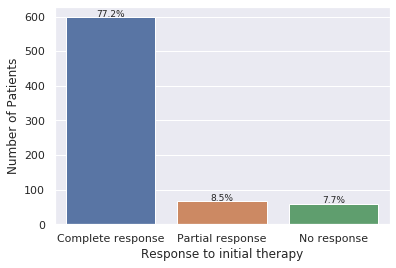

In [135]:
# sns.set(style="darkgrid")
response_hist = sns.countplot(x="Response to initial therapy", data=reddy_info)
response_hist.set_ylabel("Number of Patients")

for p in ipi_hist.patches:
    height = p.get_height()
    response_hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/775 * 100),
            ha="center", size=9)

# need to reorder
# plt.savefig("initial-rtit.png")

In [137]:
# changing 'response to initial therapy' to continuous values
values = {'Response to initial therapy': 80}
reddy_info = reddy_info.fillna(value=values)

response_col = reddy_info['Response to initial therapy'].values

for n, value in enumerate(response_col):
    if (value == 'No response'):
        response_col[n] = min(5, max(0, np.random.normal(2.5,1.5)))
        continue
    if (value == 'Partial response'):
        # maybe change to be on the lower side - SEE PG 490 REDDY
        response_col[n] = min(95, max(5, np.random.normal(55, 15)))
        continue
    if (value == 'Complete response'):
        response_col[n] = min(100, max(95, np.random.normal(95, 1.5)))
        continue
    if pd.isna(np.isnan(response_col[n])):
        print(n)
        response_col[n] = min(100, max(0, np.random.normal(60, 15)))
        continue
# convert to float64 for regression
reddy_info['Response to initial therapy'] = reddy_info[
    'Response to initial therapy'].apply(pd.to_numeric)

# keep these columns for later
reddy_info_cols = pd.DataFrame(reddy_info.columns)

# these are the relevant patient IDs to use throughout
patient_ids = pd.DataFrame(reddy_info['Sample ID'])

# create final reddy/reddy_norm expression datasets with relevant patients (n=773)
reddy = pd.merge(reddy, patient_ids, 
                      on='Sample ID', how='inner')

reddy_norm = pd.merge(reddy_norm, patient_ids, 
                      on='Sample ID', how='inner')

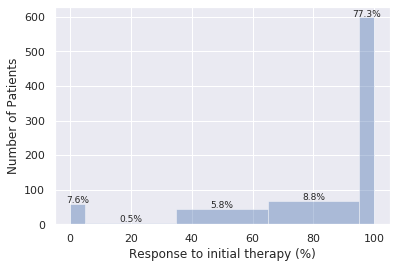

In [138]:
response_hist2 = sns.distplot(reddy_info['Response to initial therapy'], bins=[0,5,35,65,95,100], norm_hist=False, kde=False)
response_hist2.set_ylabel("Number of Patients")
response_hist2.set_xlabel("Response to initial therapy (%)")

for p in response_hist2.patches:
    height = p.get_height()
    response_hist2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/775 * 100),
            ha="center", size=9)
    
plt.savefig("rtit-distr-2.png")

In [139]:
"""
CODE (not necessarily in order):
- Impute GRM then IPI then AAD then OSY

NOTES:
- Order of imputation may produce different results

RELEVANT DATA:
- N/A

"""

# MICE: GRM
import statsmodels.imputation.mice as mice
import statsmodels.regression.linear_model as lm

reddy_info = reddy_info.rename(columns={
    "Response to initial therapy": 'ResponseToInitialTherapy'})
reddy_info = reddy_info.rename(columns={
    "ABC GCB ratio (RNAseq)": 'Ratio'})
reddy_info = reddy_info.rename(columns={
    "Genomic Risk Model": 'GRM'})
reddy_info = reddy_info.rename(columns={
    "Overall survival years": 'OverallSurvivalYears'})
reddy_info = reddy_info.rename(columns={
    "Tumor Purity": "TumorPurity"})
reddy_info = reddy_info.rename(columns={
    "ABC GCB (RNAseq)": 'ABCGCB'})

# as specified in the MICE paper, "MICE: what is it and how does it work?'", 
# we use all possible variables (i.e. all continuous) variables in the regression
grm = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears', 'TumorPurity']]

print("How many null values in GRM? ", reddy_info['GRM'].isnull().sum())

imp_grm = mice.MICEData(grm)
# formula: column to impute ~ columns you impute off of
fml_grm = "GRM ~ Ratio + GADD45B + ResponseToInitialTherapy + IPI + OverallSurvivalYears + AgeAtDiagnosis"
mice_grm = mice.MICE(fml_grm, lm.OLS, imp_grm)

results = mice_grm.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# replace original column with MICE'd column
reddy_info['GRM'] = mice_grm.data.data['GRM'].values

# check to make sure there are no more null values
print("How many null values in GRM now? ", reddy_info['GRM'].isnull().sum())

#####

# MICE: IPI

ipi = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears']]

print("How many null values in IPI? ", reddy_info['IPI'].isnull().sum())

imp_ipi = mice.MICEData(ipi)
# formula: column to impute ~ columns you impute off of
fml_ipi = "IPI ~ GRM + Ratio + GADD45B + ResponseToInitialTherapy + OverallSurvivalYears + AgeAtDiagnosis"
mice_ipi = mice.MICE(fml_ipi, lm.OLS, imp_ipi)

results = mice_ipi.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# replace original column with MICE'd column
reddy_info['IPI'] = mice_ipi.data.data['IPI'].values

print("How many null values in IPI now? ", reddy_info['GRM'].isnull().sum())


#####

# MICE: AgeAtDiagnosis

aad = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears']]

print("How many null values in AgeAtDiagnosis? ", reddy_info['IPI'].isnull().sum())

imp_add = mice.MICEData(aad)
# formula: column to impute ~ columns you impute off of
fml_aad = "AgeAtDiagnosis ~ IPI + GRM + Ratio + GADD45B + ResponseToInitialTherapy + OverallSurvivalYears"
mice_aad = mice.MICE(fml_aad, lm.OLS, imp_add)

results = mice_aad.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# replace original column with MICE'd column
reddy_info['AgeAtDiagnosis'] = mice_aad.data.data['AgeAtDiagnosis'].values

print("How many null values in AgeAtDiagnosis now? ", reddy_info['AgeAtDiagnosis'].isnull().sum())

#####

# MICE: OverallSurvivalYears

osy = reddy_info[['GRM', 'Ratio', 'GADD45B', 'AgeAtDiagnosis',
                  'ResponseToInitialTherapy', 'IPI', 'OverallSurvivalYears']]

print("How many null values in overall survival years? ",
      reddy_info['OverallSurvivalYears'].isnull().sum())

imp_osy = mice.MICEData(osy)
# formula: column to impute ~ columns you impute off of
fml_osy = "OverallSurvivalYears ~ GRM + Ratio + GADD45B + IPI+ ResponseToInitialTherapy + AgeAtDiagnosis"
mice_osy = mice.MICE(fml_osy, lm.OLS, imp_osy)

results = mice_osy.fit(10,10) # fit(#cycles to skip, #datasets to impute)
#print(results.summary())

# check to make sure there are no more null values
print("How many null values in overall survival years now? ",
      reddy_info['GRM'].isnull().sum())

# replace original column with MICE'd column
reddy_info['OverallSurvivalYears'] = mice_osy.data.data['OverallSurvivalYears'].values

print("How many null values in 'Censored'? ", reddy_info['Censored'].isnull().sum())

# since we now have complete data for 'OverallSurvivalYears', we can set the null
# censored values to being censored since we can assume the patients could not be followed up

# 0 means censored, 1 means uncensored
values = {'Censored': 0}
reddy_info = reddy_info.fillna(value=values)
print("How many null values in 'Censored' now? ", reddy_info['Censored'].isnull().sum())

print("We now have " + str(len(reddy_info)) + " patients with complete data")

How many null values in GRM?  22
How many null values in GRM now?  0
How many null values in IPI?  152
How many null values in IPI now?  0
How many null values in AgeAtDiagnosis?  0
How many null values in AgeAtDiagnosis now?  0
How many null values in overall survival years?  19
How many null values in overall survival years now?  0
How many null values in 'Censored'?  7
How many null values in 'Censored' now?  0
We now have 775 patients with complete data


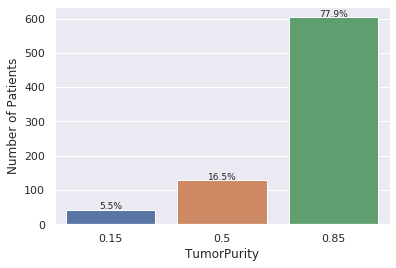

In [133]:
# sns.set(style="darkgrid")
purity_hist = sns.countplot(x="TumorPurity", data=reddy_info)
purity_hist.set_ylabel("Number of Patients")

for p in purity_hist.patches:
    height = p.get_height()
    purity_hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/775 * 100),
            ha="center", size=9)

plt.savefig("purity-distr.png")

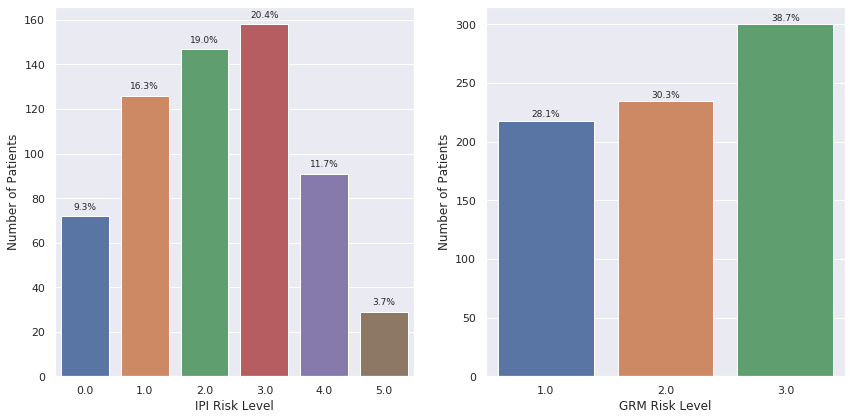

In [120]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.set(style="darkgrid")
ipi_hist = sns.countplot(x="IPI", data=reddy_info, ax=ax[0])
ipi_hist.set_ylabel("Number of Patients")
ipi_hist.set_xlabel("IPI Risk Level")

for p in ipi_hist.patches:
    height = p.get_height()
    ipi_hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/775 * 100),
            ha="center", size=9)

grm_hist = sns.countplot(x="Genomic Risk Model", data=reddy_info, ax=ax[1])
grm_hist.set_ylabel("Number of Patients")
grm_hist.set_xlabel("GRM Risk Level")

for p in grm_hist.patches:
    height = p.get_height()
    grm_hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/775 * 100),
            ha="center", size=9)

plt.tight_layout(w_pad=2)
plt.savefig("ipi-grm-distr.png")

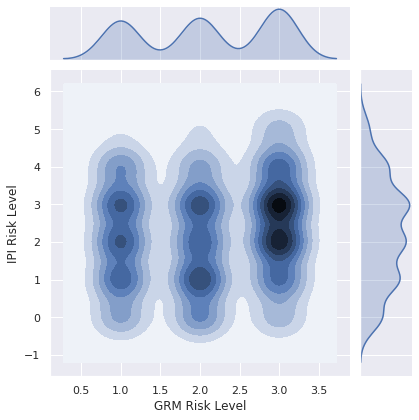

In [71]:
ipi_grm = sns.jointplot(y="IPI", x="Genomic Risk Model", data=reddy_info, kind="kde");
ipi_grm.ax_joint.set_xlabel('GRM Risk Level')
ipi_grm.ax_joint.set_ylabel('IPI Risk Level')
plt.savefig('ipi-grm-joint.png')

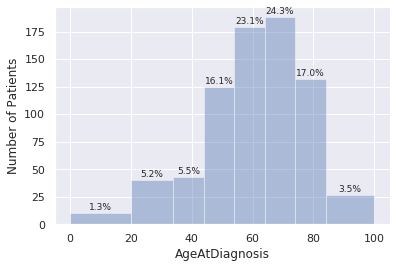

In [117]:
age_bins = [0, 20, 34, 44, 54, 64, 74, 84, 100]
age_hist = sns.distplot(reddy_info['AgeAtDiagnosis'], bins=age_bins, norm_hist=False, kde=False)
age_hist.set_ylabel("Number of Patients")

for p in age_hist.patches:
    height = p.get_height()
    age_hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/775 * 100),
            ha="center", size=9)
plt.savefig("age-distr.png")

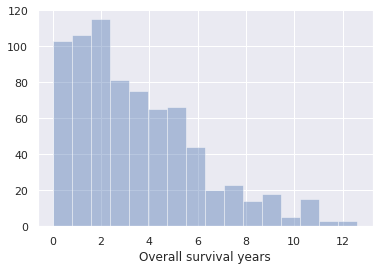

In [103]:
osy_hist = sns.distplot(reddy_info['Overall survival years'], norm_hist=False, kde=False)
plt.savefig("osy-distr.png")

In [120]:
# reddy_norm['Sample ID'].is_unique = true
hh = reddy_norm
hh = pd.merge(hh, reddy_info[['TumorPurity', 'IPI', 'AgeAtDiagnosis', 'Sample ID']], on='Sample ID', how='inner')
hh = hh[hh['TumorPurity'] > 0.3]

# calculate median from high purity data only 
ipi_med = hh['IPI'].median() 
ipi_df = []
age_med = hh['AgeAtDiagnosis'].median()
age_df = []
gadd_med = hh['GADD45B'].median()
gadd_df = []

for i, row in hh.iterrows():
    ipi_df.append(row['IPI'])
    age_df.append(row['AgeAtDiagnosis'])
    gadd_df.append(row['GADD45B'])

# first value is 1 => HIGH LOW
for i, value in enumerate(ipi_df):
    if value <= ipi_med:
        ipi_df[i] = 0
    else:
        ipi_df[i] = 1

# first value is 1 => OLD YOUNG  
for i, value in enumerate(age_df):
    if value <= age_med:
        age_df[i] = 0
    else:
        age_df[i] = 1
        
# first value is 0 => LOW HIGH  
for i, value in enumerate(gadd_df):
    if value <= gadd_med:
        gadd_df[i] = 0
    else:
        gadd_df[i] = 1

hh = hh.drop(['TumorPurity', 'IPI', 'AgeAtDiagnosis'], axis=1)
hh = hh.transpose()

age_df = pd.DataFrame(age_df).transpose()
gadd_df = pd.DataFrame(gadd_df).transpose()
ipi_df = pd.DataFrame(ipi_df).transpose()

In [121]:
hh.to_csv("reddy_norm_highpurity.xlsx") 
age_df.to_csv("reddy_age.xlsx")
ipi_df.to_csv("reddy_ipi.xlsx")
gadd_df.to_csv("reddy_gadd45b.xlsx")

In [140]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import proportional_hazard_test, multivariate_logrank_test, logrank_test

"""
CODE (not necessarily in order):
- Produce COO cohorts from reddy_info

NOTES:
- Data is just clinical info, tumor purity, GADD45B expression
- Does not include expression data apart from GADD45B

RELEVANT DATA:
- reddy_abc := abc cohort
- reddy_gcb := gcb cohort
- reddy_unc := unclassified cohort

"""

# ABC cohort
reddy_abc = reddy_info.loc[reddy_info['ABCGCB'] == 'ABC'][[
    "OverallSurvivalYears", "Censored", "IPI", "GRM", "AgeAtDiagnosis",
    "ResponseToInitialTherapy", "GADD45B", "TumorPurity", "Sample ID"]]

# GCB cohort
reddy_gcb = reddy_info.loc[reddy_info['ABCGCB'] == 'GCB'][[
    "OverallSurvivalYears", "Censored", "IPI", "GRM", "AgeAtDiagnosis",
    "ResponseToInitialTherapy", "GADD45B", "TumorPurity", "Sample ID"]]

# Unclassified cohort
reddy_unc = reddy_info.loc[reddy_info['ABCGCB'] == 'Unclassified'][[
    "OverallSurvivalYears", "Censored", "IPI", "GRM", "AgeAtDiagnosis",
    "ResponseToInitialTherapy", "GADD45B", "TumorPurity", "Sample ID"]]

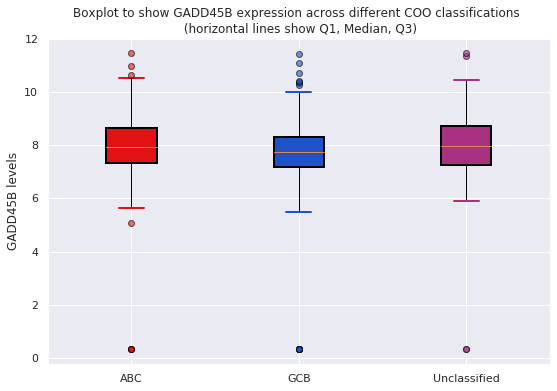

In [191]:
# Create boxplot comparing GADD45B expression level
# Perform different statistical tests to see if any results are significant

import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind, DescrStatsW

# Create a figure instance
fig = plt.figure(figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([reddy_abc['GADD45B'], reddy_gcb['GADD45B'], reddy_unc['GADD45B']], patch_artist=True)
ax = ax.set_xticklabels(['ABC', 'GCB', 'Unclassified'])

# edit ABC box
bp['boxes'][0].set(color='#000000', linewidth=2)
bp['boxes'][0].set(facecolor='#e01212')
bp['caps'][0].set(color='#e01212', linewidth=2)
bp['caps'][1].set(color='#e01212', linewidth=2)
bp['fliers'][0].set(marker='o', markerfacecolor='#e01212', alpha=0.6)

# edit GCB box
bp['boxes'][1].set(color='#000000', linewidth=2)
bp['boxes'][1].set(facecolor='#1e53c7')
bp['caps'][2].set(color='#1e53c7', linewidth=2)
bp['caps'][3].set(color='#1e53c7', linewidth=2)
bp['fliers'][1].set(marker='o', markerfacecolor='#1e53c7', alpha=0.6)

# edit Unclassified box
bp['boxes'][2].set(color='#000000', linewidth=2)
bp['boxes'][2].set(facecolor='#a83281')
bp['caps'][4].set(color='#a83281', linewidth=2)
bp['caps'][5].set(color='#a83281', linewidth=2)
bp['fliers'][2].set(marker='o', markerfacecolor='#a83281', alpha=0.6)

k = plt.ylabel("GADD45B levels")

l = plt.title("Boxplot to show GADD45B expression across different COO classifications \n (horizontal lines show Q1, Median, Q3)")

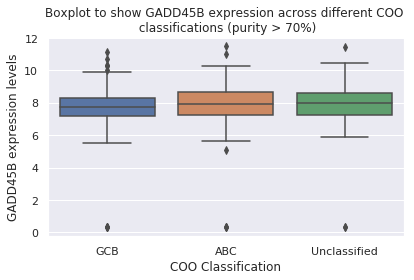

In [226]:
hi = reddy_info[reddy_info['TumorPurity'] > 0.7]
bp = sns.boxplot(x="ABCGCB", y="GADD45B", data=hi[['GADD45B', 'ABCGCB']])
bp.set_ylabel("GADD45B expression levels")
bp.set_xlabel("COO Classification")
bp.set_title("Boxplot to show GADD45B expression across different COO \n classifications (purity > 70%)")
plt.tight_layout()
plt.savefig("coo-box-high.png")

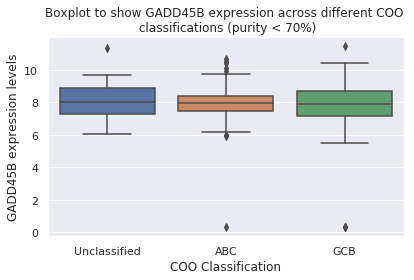

In [225]:
hi = reddy_info[reddy_info['TumorPurity'] < 0.7]
bp = sns.boxplot(x="ABCGCB", y="GADD45B", data=hi[['GADD45B', 'ABCGCB']])
bp.set_ylabel("GADD45B expression levels")
bp.set_xlabel("COO Classification")
bp.set_title("Boxplot to show GADD45B expression across different COO \n classifications (purity < 70%)")
plt.tight_layout()
plt.savefig("coo-box-low.png")

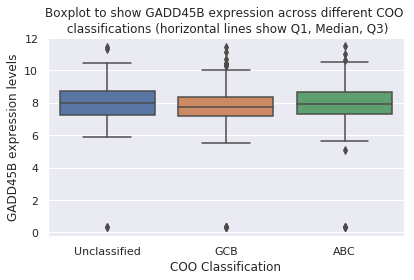

In [187]:
bp = sns.boxplot(x="ABCGCB", y="GADD45B", data=reddy_info[['GADD45B', 'ABCGCB']])
bp.set_ylabel("GADD45B expression levels")
bp.set_xlabel("COO Classification")
bp.set_title("Boxplot to show GADD45B expression across different COO \n classifications (horizontal lines show Q1, Median, Q3)")
plt.tight_layout()
plt.savefig("coo-box.png")

In [195]:
# may neeed to check assumptions: https://pythonfordatascience.org/independent-t-test-python/#assumps_check


def two_way_stats_tests(abc, gcb, unc):

    # anova - parametric so each group's needs to be normally distributed for F-statistic to be reliable
    _, anova_p = stats.f_oneway(abc['GADD45B'], gcb['GADD45B'], unc['GADD45B'])

    print("Using ANOVA one-way test, the p-value was " + str(round(anova_p, 3)) + " and so don't reject H0.")
    print()

    # t-test between pairs of cohorts
    _, t_test_abcgcb_p, _ = ttest_ind(abc['GADD45B'], gcb['GADD45B'])
    _, t_test_abcunc_p, _ = ttest_ind(abc['GADD45B'], unc['GADD45B'])
    _, t_test_gcbunc_p, _ = ttest_ind(gcb['GADD45B'], unc['GADD45B'])

    t_ag_p = str(round(t_test_abcgcb_p, 3))
    t_ag_p_decision = " and so don't reject H0." if (t_test_abcgcb_p >= 0.05) else " and so can reject H0."
    print("Using independent two-sample t-test between ABC and GCB, the p-value was " + t_ag_p + t_ag_p_decision)

    t_au_p = str(round(t_test_abcunc_p, 3))
    t_au_p_decision = " and so don't reject H0." if (t_test_abcunc_p >= 0.05) else " and so can reject H0."
    print("Using independent two-sample t-test between ABC and Unclassifed, the p-value was " +
          t_au_p + t_au_p_decision)

    t_gu_p = str(round(t_test_gcbunc_p, 3))
    t_gu_p_decision = " and so don't reject H0." if (t_test_gcbunc_p >= 0.05) else " and so can reject H0."
    print("Using independent two-sample t-test between GCB and Unclassified, the p-value was " +
          t_gu_p + t_gu_p_decision)

    print()

    # welch's t-test between pairs of cohorts
    _, welch_abcgcb_p = stats.ttest_ind(abc['GADD45B'], gcb['GADD45B'], equal_var=False)
    _, welch_abcunc_p = stats.ttest_ind(abc['GADD45B'], unc['GADD45B'], equal_var=False)
    _, welch_gcbunc_p = stats.ttest_ind(gcb['GADD45B'], unc['GADD45B'], equal_var=False)

    w_ag_p = str(round(welch_abcgcb_p, 3))
    w_ag_p_decision = " and so don't reject H0." if (welch_abcgcb_p >= 0.05) else " and so can reject H0."
    print("Using Welch's t-test between ABC and GCB, the p-value was " + w_ag_p + w_ag_p_decision)

    w_au_p = str(round(welch_abcunc_p, 3))
    w_au_p_decision = " and so don't reject H0." if (welch_abcunc_p >= 0.05) else " and so can reject H0."
    print("Using Welch's t-test between ABC and Unclassified, the p-value was " + w_au_p + w_au_p_decision)

    w_gu_p = str(round(welch_gcbunc_p, 3))
    w_gu_p_decision = " and so don't reject H0." if (welch_gcbunc_p >= 0.05) else " and so can reject H0."
    print("Using Welch's t-test between GCB and Unclassified, the p-value was " + w_gu_p + w_gu_p_decision)

two_way_stats_tests(reddy_abc, reddy_gcb, reddy_unc)

print("----------------------")
print("Now the same tests but performed only on samples with tumor purity > 70%")
print("----------------------")

two_way_stats_tests(reddy_abc[reddy_abc['TumorPurity'] > 0.7],
                    reddy_gcb[reddy_gcb['TumorPurity'] > 0.7],
                    reddy_unc[reddy_unc['TumorPurity'] > 0.7])


print("----------------------")
print("Now the same tests but performed only on samples with tumor purity < 70%")
print("----------------------")

two_way_stats_tests(reddy_abc[reddy_abc['TumorPurity'] < 0.7],
                    reddy_gcb[reddy_gcb['TumorPurity'] < 0.7],
                    reddy_unc[reddy_unc['TumorPurity'] < 0.7])


Using ANOVA one-way test, the p-value was 0.028 and so don't reject H0.

Using independent two-sample t-test between ABC and GCB, the p-value was 0.02 and so can reject H0.
Using independent two-sample t-test between ABC and Unclassifed, the p-value was 0.747 and so don't reject H0.
Using independent two-sample t-test between GCB and Unclassified, the p-value was 0.042 and so can reject H0.

Using Welch's t-test between ABC and GCB, the p-value was 0.019 and so can reject H0.
Using Welch's t-test between ABC and Unclassified, the p-value was 0.754 and so don't reject H0.
Using Welch's t-test between GCB and Unclassified, the p-value was 0.043 and so can reject H0.
----------------------
Now the same tests but performed only on samples with tumor purity > 70%
----------------------
Using ANOVA one-way test, the p-value was 0.093 and so don't reject H0.

Using independent two-sample t-test between ABC and GCB, the p-value was 0.04 and so can reject H0.
Using independent two-sample t-test

In [ ]:
# left this function in but no longer being used

"""
CODE (not necessarily in order):
- Create Kaplan-Meier graphs to compare two cohorts

NOTES:
- Results were not significant so this function is no longer being used

RELEVANT DATA:
- N/A

"""

def create_km(cohort, split_values, cohort_str):
    """
    This function produces a Kaplan-Meier survival curve of the cohort stratified on the given split values.
    The split values are the normalised quantiles (given as decimals between 0 and 1) which are used to
    calculate the corresponding GADD45B quantile.
    
    maybe add test type for log-rank? or weighted k-m?

    Args:
        cohort: Patient data passed in which has to contain no null values and needs 'GADD45B', 
            'OverallSurvivalYears', and 'Censored' categories.
        split_values: A list of two elements, both between 0 and 1, which help calculate the GADD45B 
            quantiles to split on.
        cohort_str: A string to include at the top of the graph title. Corresponds to the cohort. 
            e.g. reddy_abc cohort has cohort_str = "ABC".

    Returns:
        No return value.

    """
    # get corresponding GADD45B quantiles
    gadd45b_split_values = cohort['GADD45B'].quantile([split_values[0], split_values[1]])
    low_split, high_split = gadd45b_split_values

    # create low and high patient stratifications using quantiles
    low_subset = cohort[cohort['GADD45B'] < low_split]
    high_subset = cohort[cohort['GADD45B'] >= high_split]
    
    low_lab = "Low GADD45B (n = " + str(len(low_subset)) + ")"
    high_lab = "High GADD45B (n = " + str(len(high_subset)) + ")"
    
    # plot both subsets as kaplan-meier survival curves
    kmf = KaplanMeierFitter()
    kmf.fit(low_subset['OverallSurvivalYears'].values, low_subset['Censored'].values, label=low_lab)
    kmf.plot(ci_show=False)
    kmf.fit(high_subset['kOverallSurvivalYears'].values, high_subset['Censored'].values, label=high_lab)
    kmf.plot(ci_show=False)
    plt.title(cohort_str + " Kaplan-Meier plot for\n low and high GADD45B expression")
    
    # add percentage of cohorts used in low and high subsets to graph
    low_percent = str(round(split_values[0]*100, 3))
    high_percent = str(round((1-split_values[1])*100, 3))
    plt.text(7, 0.7, "low = bottom " + low_percent + "% \n high = top " + high_percent + "%")
    
    # perform log-rank test to measure (dis)similarity between two subsets of cohort
    logrank = logrank_test(low_subset['OverallSurvivalYears'], high_subset['OverallSurvivalYears'],
                      event_observed_A=low_subset['Censored'], event_observed_B=high_subset['Censored'])
    
    # add p-value and null hypothesis status to graph
    p_value = round(logrank.p_value, 3)
    p_decision = "Don't reject H0" if (p_value >= 0.05) else "Can reject H0"
    plt.text(8, 0.5, "p = " + str(p_value) + "\n" + p_decision)
    
    # display graph
    # plt.show()
    

#####

# Quantiles to iterate over. List[[low, high]]
split_pairs = [[0.9, 0.9], [0.8, 0.8], [0.667, 0.667], [0.5, 0.5], [0.333, 0.333], 
               [0.2, 0.2], [0.1, 0.1], [0.25, 0.75], [0.333, 0.667]]


#####


### full dataset
from math import ceil, sqrt

n = ceil(sqrt(len(split_pairs)))

# all purities
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_info, pair, "Full dataset (all purities)")
    
# purities > 45%   
reddy_info_high_purity = reddy_info[reddy_info['TumorPurity'] >= 0.45]
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_info_high_purity, pair, "Full dataset (purity > 45%)")
    
"""
### ABC

# all purities
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_abc, pair, "ABC (all purities)")
    
# purities > 45%   
reddy_abc_high_purity = reddy_abc[reddy_abc['TumorPurity'] >= 0.45]
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_abc_high_purity, pair, "ABC (purity > 45%)")

### GCB

# all purities
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_gcb, pair, "GCB (all purities)")
    
# purities > 45%   
reddy_gcb_high_purity = reddy_gcb[reddy_gcb['TumorPurity'] >= 0.45]
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_gcb_high_purity, pair, "GCB (purity > 45%)")

### Unclassified

# all purities
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_unc, pair, "Unclassified (all purities)")
    
# purities > 45%   
reddy_unc_high_purity = reddy_unc[reddy_unc['TumorPurity'] >= 0.45]
fig, axarr = plt.subplots(n, n, figsize=(20,20))
for i, pair in enumerate(split_pairs):
    plt.subplot(n, n, i+1)    
    create_km(reddy_unc_high_purity, pair, "Unclassified (purity > 45%)")

"""

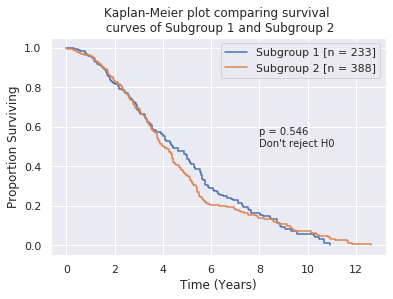

In [299]:
# simple KM plot for background

simple_cohort = reddy_info[["OverallSurvivalYears", "Censored", "GADD45B"]]
simple_cohort = simple_cohort.rename(columns={"GADD45B": "Variable1"})

split_values = [0.3, 0.5]

# get corresponding GADD45B quantiles
gadd45b_split_values = simple_cohort['Variable1'].quantile(split_values)
low_split, high_split = gadd45b_split_values

# create low and high patient stratifications using quantiles
low_subset = simple_cohort[simple_cohort['Variable1'] < low_split]
high_subset = simple_cohort[simple_cohort['Variable1'] >= high_split]

low_lab = "Subgroup 1 [n = " + str(len(low_subset)) + "]"
high_lab = "Subgroup 2 [n = " + str(len(high_subset)) + "]"

# plot both subsets as kaplan-meier survival curves
kmf = KaplanMeierFitter()
kmf.fit(low_subset['OverallSurvivalYears'].values, low_subset['Censored'].values, label=low_lab)
kmf.plot(ci_show=False)
kmf.fit(high_subset['OverallSurvivalYears'].values, high_subset['Censored'].values, label=high_lab)
kmf.plot(ci_show=False)
plt.title("Kaplan-Meier plot comparing survival \n curves of Subgroup 1 and Subgroup 2")
plt.xlabel("Time (Years)")
plt.ylabel("Proportion Surviving")

# perform log-rank test to measure (dis)similarity between two subsets of cohort
logrank = logrank_test(low_subset['OverallSurvivalYears'], high_subset['OverallSurvivalYears'],
                  event_observed_A=low_subset['Censored'], event_observed_B=high_subset['Censored'])

# add p-value and null hypothesis status to graph
p_value = round(logrank.p_value, 3)
p_decision = "Don't reject H0" if (p_value >= 0.05) else "Can reject H0"
plt.text(8, 0.5, "p = " + str(p_value) + "\n" + p_decision)

plt.savefig("simple-km.png")

Proportional hazard assumption looks okay.


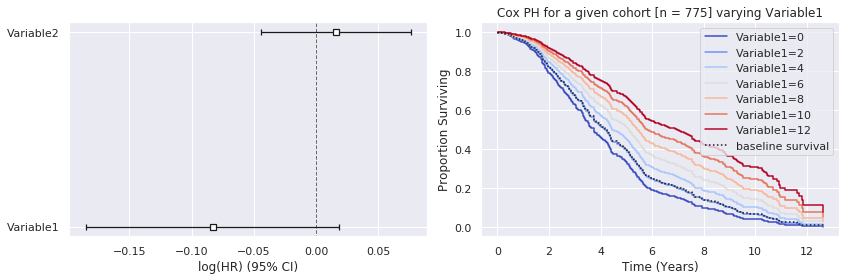

In [223]:
# simple Cox PH example used for background

fig, axarr = plt.subplots(1, 2, figsize=(12,4), squeeze=False)

simple_cohort = reddy_info[["OverallSurvivalYears", "Censored", "GRM", "GADD45B"]]

simple_cohort = simple_cohort.rename(columns={"GRM": "Variable1", "GADD45B": "Variable2"})

n_all = len(simple_cohort)

cph = CoxPHFitter(penalizer=0.05)
cph.fit(simple_cohort, duration_col='OverallSurvivalYears', event_col='Censored')

# plot graph # need to add x and y
plot_title = "Cox PH for a given cohort [n = " + str(n_all) + "] varying Variable1" 

# Check assumptions for full cohort and plot hazard ratios
cph.check_assumptions(simple_cohort, p_value_threshold=0, show_plots=False)
cph.plot(ax=axarr[0][0])
cph.plot_covariate_groups('Variable1', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                 ax=axarr[0][1])
axarr[0][1].set_xlabel("Time (Years)")
axarr[0][1].set_ylabel("Proportion Surviving")

"""
cph.plot_covariate_groups('Variable2', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                 ax=axarr[0][2])
axarr[0][2].set_xlabel("Time (Years)")
axarr[0][2].set_ylabel("Proportion Surviving")

"""


cph.print_summary()

fig.tight_layout()
# plt.savefig("simple-cox.png")

In [177]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test, multivariate_logrank_test

"""
CODE (not necessarily in order):
- Create Cox proportional hazards graphs for different cohorts
- Cohorts are COO classifications

NOTES:
- Cross-validation may be relevant later
- Include n

RELEVANT DATA:
- N/A

"""

# potential quantiles to iterate over. List[[low, high]] # could be used for purity too
split_pairs = [[0.9, 0.9], [0.8, 0.8], [0.667, 0.667], [0.5, 0.5], [0.333, 0.333], 
               [0.2, 0.2], [0.1, 0.1], [0.25, 0.75], [0.333, 0.667]]

# this one can be for low and high purities

def create_coxph_purity(cohort_data, cohort_name, low_pur_thresh, high_pur_thresh):
    
    # create axes for plots
    fig, axarr = plt.subplots(3, 2, figsize=(12,12))
    fig.tight_layout(w_pad=3, h_pad=3.5)
    
    #cohort = cohort_data[["OverallSurvivalYears", "Censored", "IPI", "TumorPurity", 
    #                     "AgeAtDiagnosis", "ResponseToInitialTherapy", "GADD45B", "GRM"]]
    # IPI wasn't satisfying proportional hazards so removed
    cohort = cohort_data[["OverallSurvivalYears", "Censored", "TumorPurity", "IPI",
                         "AgeAtDiagnosis", "ResponseToInitialTherapy", "GADD45B", "GRM"]]
    
    
    ### all purities

    cohort_all_pur = cohort.drop(['TumorPurity'], axis=1)
    n_all = len(cohort_all_pur)
    
    # need to add proper penalty to mimic elastic net
    cph_all_pur = CoxPHFitter(penalizer=0.05)
    cph_all_pur.fit(cohort_all_pur, duration_col='OverallSurvivalYears', event_col='Censored')
    #cph_all_pur.print_summary()
    
    # plot graph # need to add x and y
    plot_title = "Cox PH for " + cohort_name + " cohort with all purities \n [n = " + str(n_all) + "] varying GADD45B expression" 
    
    # Check assumptions for full cohort and plot hazard ratios
    cph_all_pur.check_assumptions(cohort_all_pur, p_value_threshold=0, show_plots=False)
    cph_all_pur.plot(ax=axarr[0][0])
    cph_all_pur.plot_covariate_groups('GADD45B', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                     ax=axarr[0][1])
    axarr[0][1].set_xlabel("Time (Years)")
    axarr[0][1].set_ylabel("Proportion Surviving")
    
    ### high purity
    cohort_high_pur = cohort[cohort['TumorPurity'] > high_pur_thresh]
    cohort_high_pur = cohort_high_pur.drop(['TumorPurity'], axis=1)
    n_high = len(cohort_high_pur)
    
    # need to add proper penalty to mimic elastic net
    cph_high_pur = CoxPHFitter(penalizer=0.05)
    cph_high_pur.fit(cohort_high_pur, duration_col='OverallSurvivalYears', event_col='Censored')
    #cph_high_pur.print_summary()
    
    # plot graph # need to add x and y
    plot_title = "Cox PH for " + cohort_name + " cohort with high purities  (>" + str(high_pur_thresh*100) + "%) \n  [n = " + str(n_high) + "] varying GADD45B expression" 
    
    # Check assumptions for high purity cohort and plot hazard ratios
    cph_high_pur.check_assumptions(cohort_high_pur, p_value_threshold=0, show_plots=False)
    cph_high_pur.plot(ax=axarr[1][0])
    
    cph_high_pur.plot_covariate_groups('GADD45B', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                     ax=axarr[1][1])
    axarr[1][1].set_xlabel("Time (Years)")
    axarr[1][1].set_ylabel("Proportion Surviving")
    
    ### low purity
    cohort_low_pur = cohort[cohort['TumorPurity'] < low_pur_thresh]
    cohort_low_pur = cohort_low_pur.drop(['TumorPurity'], axis=1)
    n_low = len(cohort_low_pur)
    
    # need to add proper penalty to mimic elastic net
    cph_low_pur = CoxPHFitter(penalizer=0.05)
    cph_low_pur.fit(cohort_low_pur, duration_col='OverallSurvivalYears', event_col='Censored')
    #cph_high_pur.print_summary()
    
    # plot graph # need to add x and y
    plot_title = "Cox PH for " + cohort_name + " cohort with low purities (<" + str(low_pur_thresh*100) + "%) \n [n = " + str(n_low) + "] varying GADD45B expression" 
    
    # Check assumptions for low purity cohort and plot hazard ratios
    cph_low_pur.check_assumptions(cohort_low_pur, p_value_threshold=0, show_plots=False)
    cph_low_pur.plot(ax=axarr[2][0])
    
    cph_low_pur.plot_covariate_groups('GADD45B', [0, 2, 4, 6, 8, 10, 12], cmap='coolwarm', title=plot_title,
                                     ax=axarr[2][1])
    axarr[2][1].set_xlabel("Time (Years)")
    axarr[2][1].set_ylabel("Proportion Surviving")
    
    return cph_all_pur, cph_high_pur, cph_low_pur
    

In [ ]:
# Full cohort
cph_all, cph_high, cph_low = create_coxph_purity(reddy_info, "full", 0.7, 0.7)
plt.tight_layout()
plt.savefig("full-cph.png")
# cph_high.summary

In [ ]:
# ABC cohort
cph_all_abc, cph_high_abc, cph_low_abc = create_coxph_purity(reddy_abc, "ABC", 0.7, 0.7)
plt.tight_layout()
plt.savefig("abc-cph.png")

In [ ]:
# GCB cohort
cph_all_gcb, cph_high_gcb, cph_low_gcb = create_coxph_purity(reddy_gcb, "GCB", 0.7, 0.7)
plt.tight_layout()
plt.savefig("gcb-cph.png")

In [ ]:
# Unclassified cohort
cph_all_unc, cph_high_unc, cph_low_unc = create_coxph_purity(reddy_unc, "Unclassified", 0.7, 0.7)
plt.tight_layout()
plt.savefig("unc-cph.png")

In [227]:
"""
CODE (not necessarily in order):
- Read in signature data
- Create signature vs GADD45B expression graphs for three highlighted signature types

NOTES:
- Currently using median of signature for correlation -> should maybe change to better method

RELEVANT DATA:
- nfkb_signatures := all nfkb signatures

TODO:
- For each signature, COO classification and maybe purity -> add flag in function

"""

import seaborn as sns

# read in signature data
nfkb_signatures = pd.read_excel('nfkb_signatures.xls')

def create_and_plot_signature(sig, coo_cohort, cohort_str):

    # get lists of signature genes present and not present in expression data
    sig_missing = [gene for gene in nfkb_signatures[sig] if not reddy_norm.columns.contains(gene)]
    sig_existing = [gene for gene in nfkb_signatures[sig] if reddy_norm.columns.contains(gene)]

    print("The Reddy expression data is missing the " + str(sig_missing) + 
          " genes used in the NF-kB " + sig + " signature.\n")

    # add existing genes to signature with 'Sample ID'
    sig_existing.append('Sample ID')
    final_sig = reddy_norm[sig_existing]
    
    # remove nan columns (happens because of different number of genes per signature)
    final_sig = final_sig.loc[:, final_sig.columns.notnull()]
    
    # remove duplicated columns
    final_sig = final_sig.loc[:,~final_sig.columns.duplicated()]
    
    # make sure same number of patients in signature and original data
    if len(final_sig) == len(reddy_norm):  
        
        # genes in final sig
        final_sig_genes = final_sig.drop(columns=['Sample ID']).columns
        
        # add median of signature to signature
        sig_gadd45b = final_sig
        sig_gadd45b['MedianOfSig'] = sig_gadd45b[final_sig_genes].median(axis=1)
        sig_gadd45b = sig_gadd45b.drop(columns=final_sig_genes)
        
        # join to COO cohort
        sig_gadd45b = pd.merge(sig_gadd45b, coo_cohort[['Sample ID']], on='Sample ID', how='inner')
        
        # now add gadd45b for scatter, original tumor purity for colour
        sig_gadd45b = pd.merge(sig_gadd45b, reddy_norm[['Sample ID', 'GADD45B']], on='Sample ID', how='inner')
        
        # setting up plot
        plot_title = "Correlation of GADD45B expression with the " + sig + "\n NF-kB target-gene signature in " + cohort_str + " cohort"
        y_label = sig + " Signature"
                
        # y = NF-kB; x = GADD45B expression
        ax = sns.regplot(sig_gadd45b['GADD45B'], sig_gadd45b['MedianOfSig'], color='black')
        ax.set_title(plot_title)
        ax.set_xlabel("GADD45B Expression")
        ax.set_ylabel(y_label)
        
        # pearson correlation coefficient
        (r, p) = pearsonr(sig_gadd45b['GADD45B'], sig_gadd45b['MedianOfSig'])
        ax.annotate("r = {:.3f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=15)
        ax.annotate("p = {:.3e}".format(p),
                xy=(.1, .85), xycoords=ax.transAxes, fontsize=15)

    else:
        raise ValueError("Number of patients in signature is not equal to original number of patients.")
     
    # return final_sig
    
coo_cohorts = [(reddy_info, "Full"), (reddy_abc, "ABC"), (reddy_gcb, "GCB"), (reddy_unc, "Unclassified")]

low_pur_thresh = 0.6
high_pur_thresh = 0.6

In [265]:
"""
CODE (not necessarily in order):
- Read in signature data
- Create signature vs GADD45B expression graphs for three highlighted signature types

NOTES:
- Currently using median of signature for correlation -> should maybe change to better method

RELEVANT DATA:
- nfkb_signatures := all nfkb signatures

TODO:
- For each signature, COO classification and maybe purity -> add flag in function

"""

import seaborn as sns

# read in signature data
nfkb_signatures = pd.read_excel('nfkb_signatures.xls')

def create_and_plot_signature(sig, coo_cohort, cohort_str, axis):

    # get lists of signature genes present and not present in expression data
    sig_missing = [gene for gene in nfkb_signatures[sig] if not (gene in reddy_norm.columns)]
    sig_existing = [gene for gene in nfkb_signatures[sig] if (gene in reddy_norm.columns)]

    print("The Reddy expression data is missing the " + str(sig_missing) + 
          " genes used in the NF-kB " + sig + " signature.\n")

    # add existing genes to signature with 'Sample ID'
    sig_existing.append('Sample ID')
    final_sig = reddy_norm[sig_existing]
    
    # remove nan columns (happens because of different number of genes per signature)
    final_sig = final_sig.loc[:, final_sig.columns.notnull()]
    
    # remove duplicated columns
    final_sig = final_sig.loc[:,~final_sig.columns.duplicated()]
    
    # make sure same number of patients in signature and original data
    if len(final_sig) == len(reddy_norm):  
        
        # genes in final sig
        final_sig_genes = final_sig.drop(columns=['Sample ID']).columns
        
        # add median of signature to signature
        sig_gadd45b = final_sig
        sig_gadd45b['MedianOfSig'] = sig_gadd45b[final_sig_genes].median(axis=1)
        sig_gadd45b = sig_gadd45b.drop(columns=final_sig_genes)
        
        # join to COO cohort
        sig_gadd45b = pd.merge(sig_gadd45b, coo_cohort[['Sample ID']], on='Sample ID', how='inner')
        
        # now add gadd45b for scatter, original tumor purity for colour
        sig_gadd45b = pd.merge(sig_gadd45b, reddy_norm[['Sample ID', 'GADD45B']], on='Sample ID', how='inner')
        
        # setting up plot
        plot_title = "Correlation of GADD45B expression with the " + sig + " NF-kB \n target-gene signature in " + cohort_str + " cohort"
        y_label = sig + " Signature"
                
        # y = NF-kB; x = GADD45B expression
        ax = sns.regplot(sig_gadd45b['GADD45B'], sig_gadd45b['MedianOfSig'], color='black', ax=axis)
        ax.set_title(plot_title)
        ax.set_xlabel("GADD45B Expression")
        ax.set_ylabel(y_label)
        
        # pearson correlation coefficient
        (r, p) = pearsonr(sig_gadd45b['GADD45B'], sig_gadd45b['MedianOfSig'])
        ax.annotate("r = {:.3f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=15)
        ax.annotate("p = {:.3e}".format(p),
                xy=(.1, .85), xycoords=ax.transAxes, fontsize=15)

    else:
        raise ValueError("Number of patients in signature is not equal to original number of patients.")
     
    # return final_sig
    
coo_cohorts = [(reddy_info, "full"), (reddy_abc, "ABC"), (reddy_gcb, "GCB"), (reddy_unc, "Unclassified")]

def plot_signature_purities(sig, low_pur_thresh, high_pur_thresh):
    fig, axarr = plt.subplots(4, 3, figsize=(20,25))
    fig.tight_layout(w_pad=3, h_pad=5)
    for i, (cohort, c_name) in enumerate(coo_cohorts):
    
        low_c = cohort[cohort['TumorPurity'] < low_pur_thresh]
        low_name = c_name + " (low purities < " + str(low_pur_thresh*100) + "%) [n = " + str(len(low_c)) + "]"
        create_and_plot_signature(sig, low_c, low_name, axarr[i][0])

        high_c = cohort[cohort['TumorPurity'] > high_pur_thresh]
        high_name = c_name + " (high purities > " + str(high_pur_thresh*100) + "%) [n = " + str(len(high_c)) + "]"
        create_and_plot_signature(sig, high_c, high_name, axarr[i][1])

        full_name = c_name + " (all purities) [n = " + str(len(cohort)) + "]"
        create_and_plot_signature(sig, cohort, full_name, axarr[i][2])

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 'LOC283663', 'MMP7'] genes used in the NF-kB STAU

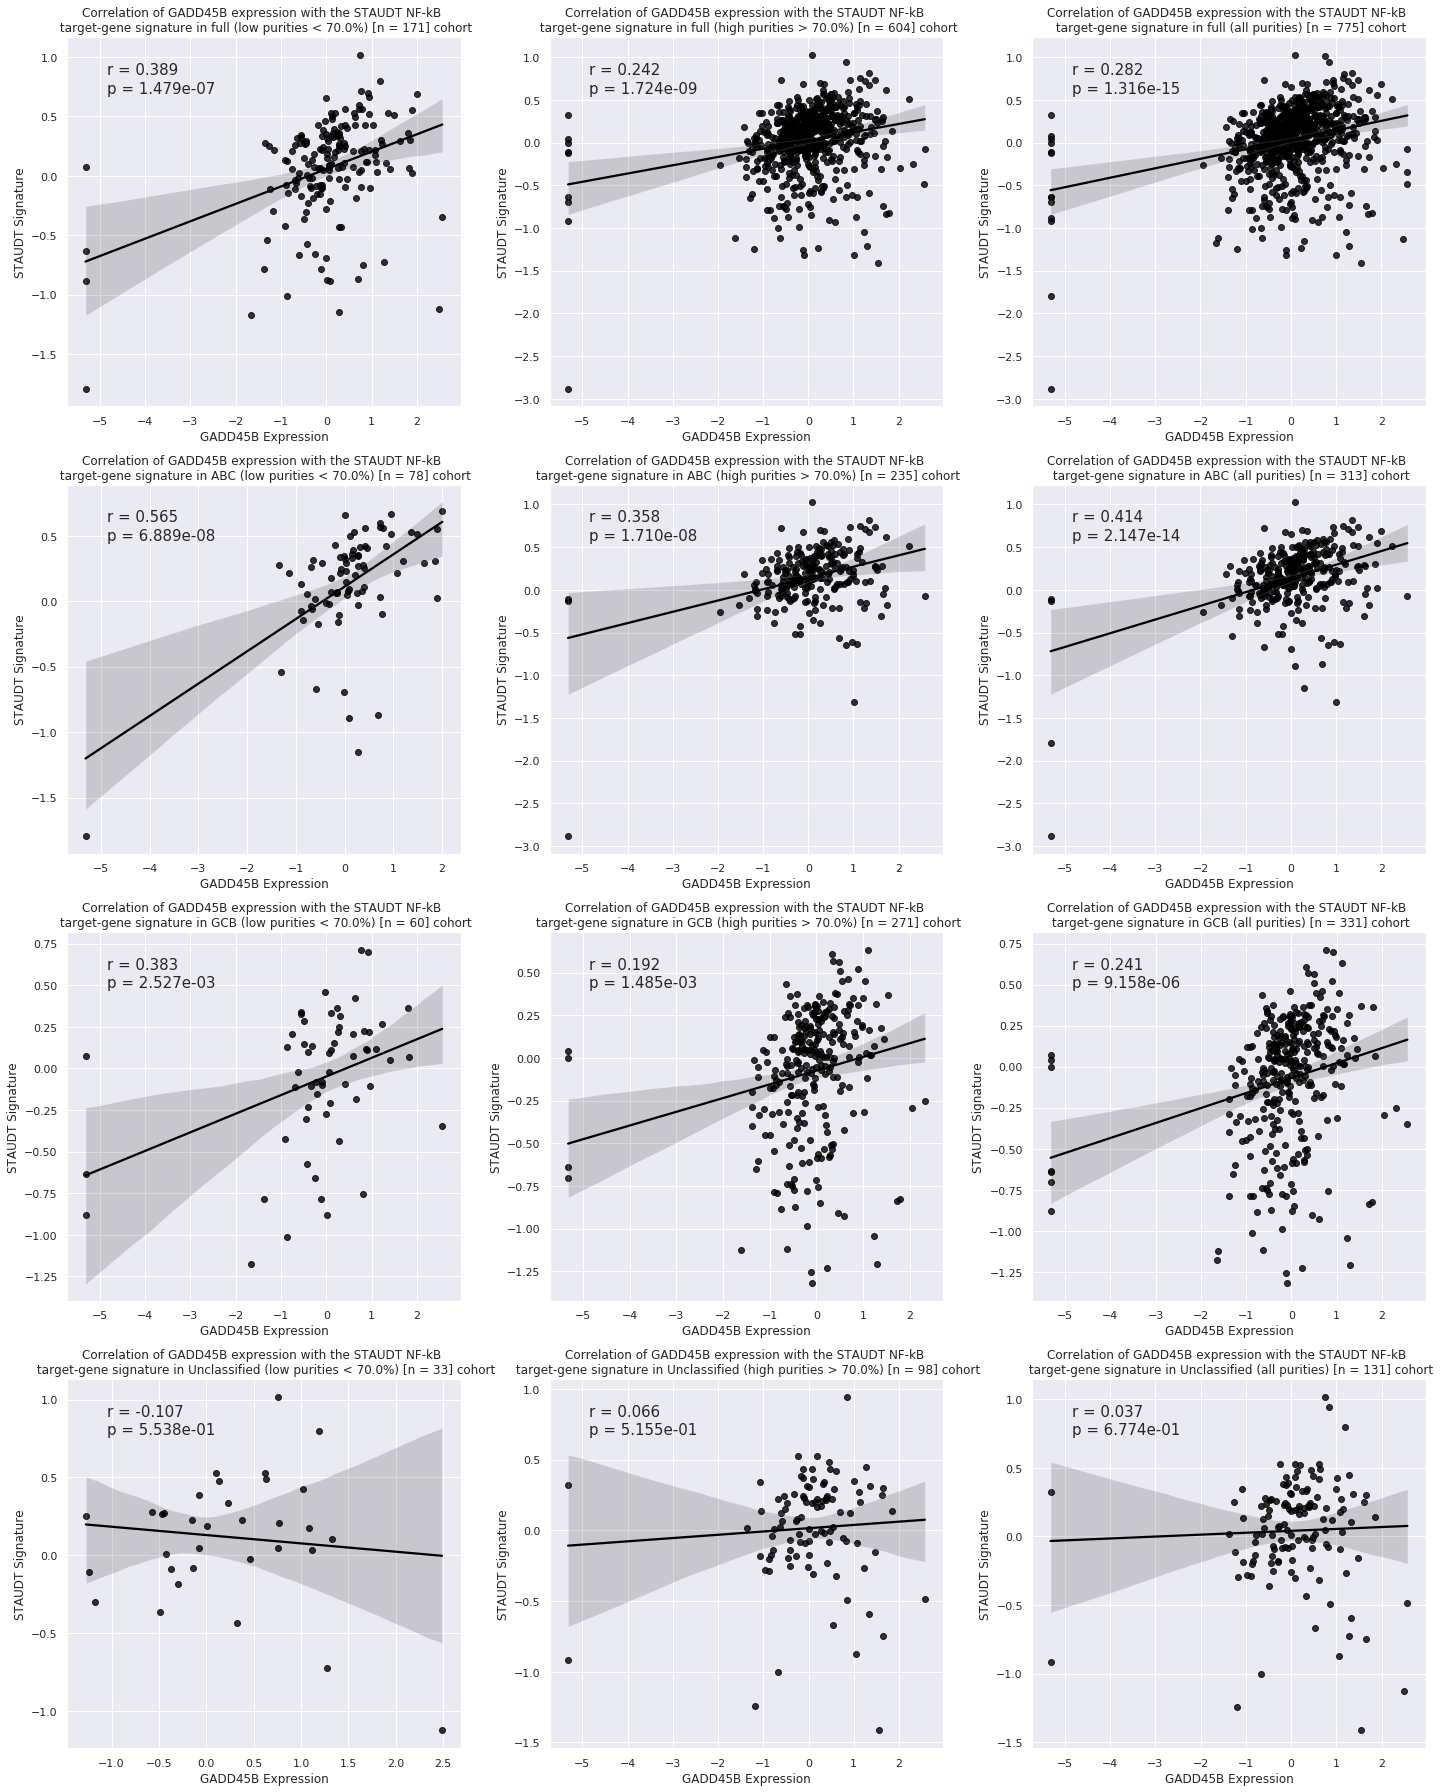

In [277]:
"""
STAUDT signature

The Reddy expression data is missing the ['FAM65B', 'IL12B', 'IL6', 'LOC154761', 
'LOC283663', 'MMP7'] genes used in the NF-kB STAUDT signature.
"""

plot_signature_purities('STAUDT', low_pur_thresh=0.7, high_pur_thresh=0.7)
plt.tight_layout()
plt.savefig('staudt.png')

The Reddy expression data is missing the [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB ANNUNZIATA signature.

The Reddy expression data is missing the [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB ANNUNZIATA signature.

The Reddy expression data is missing the [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

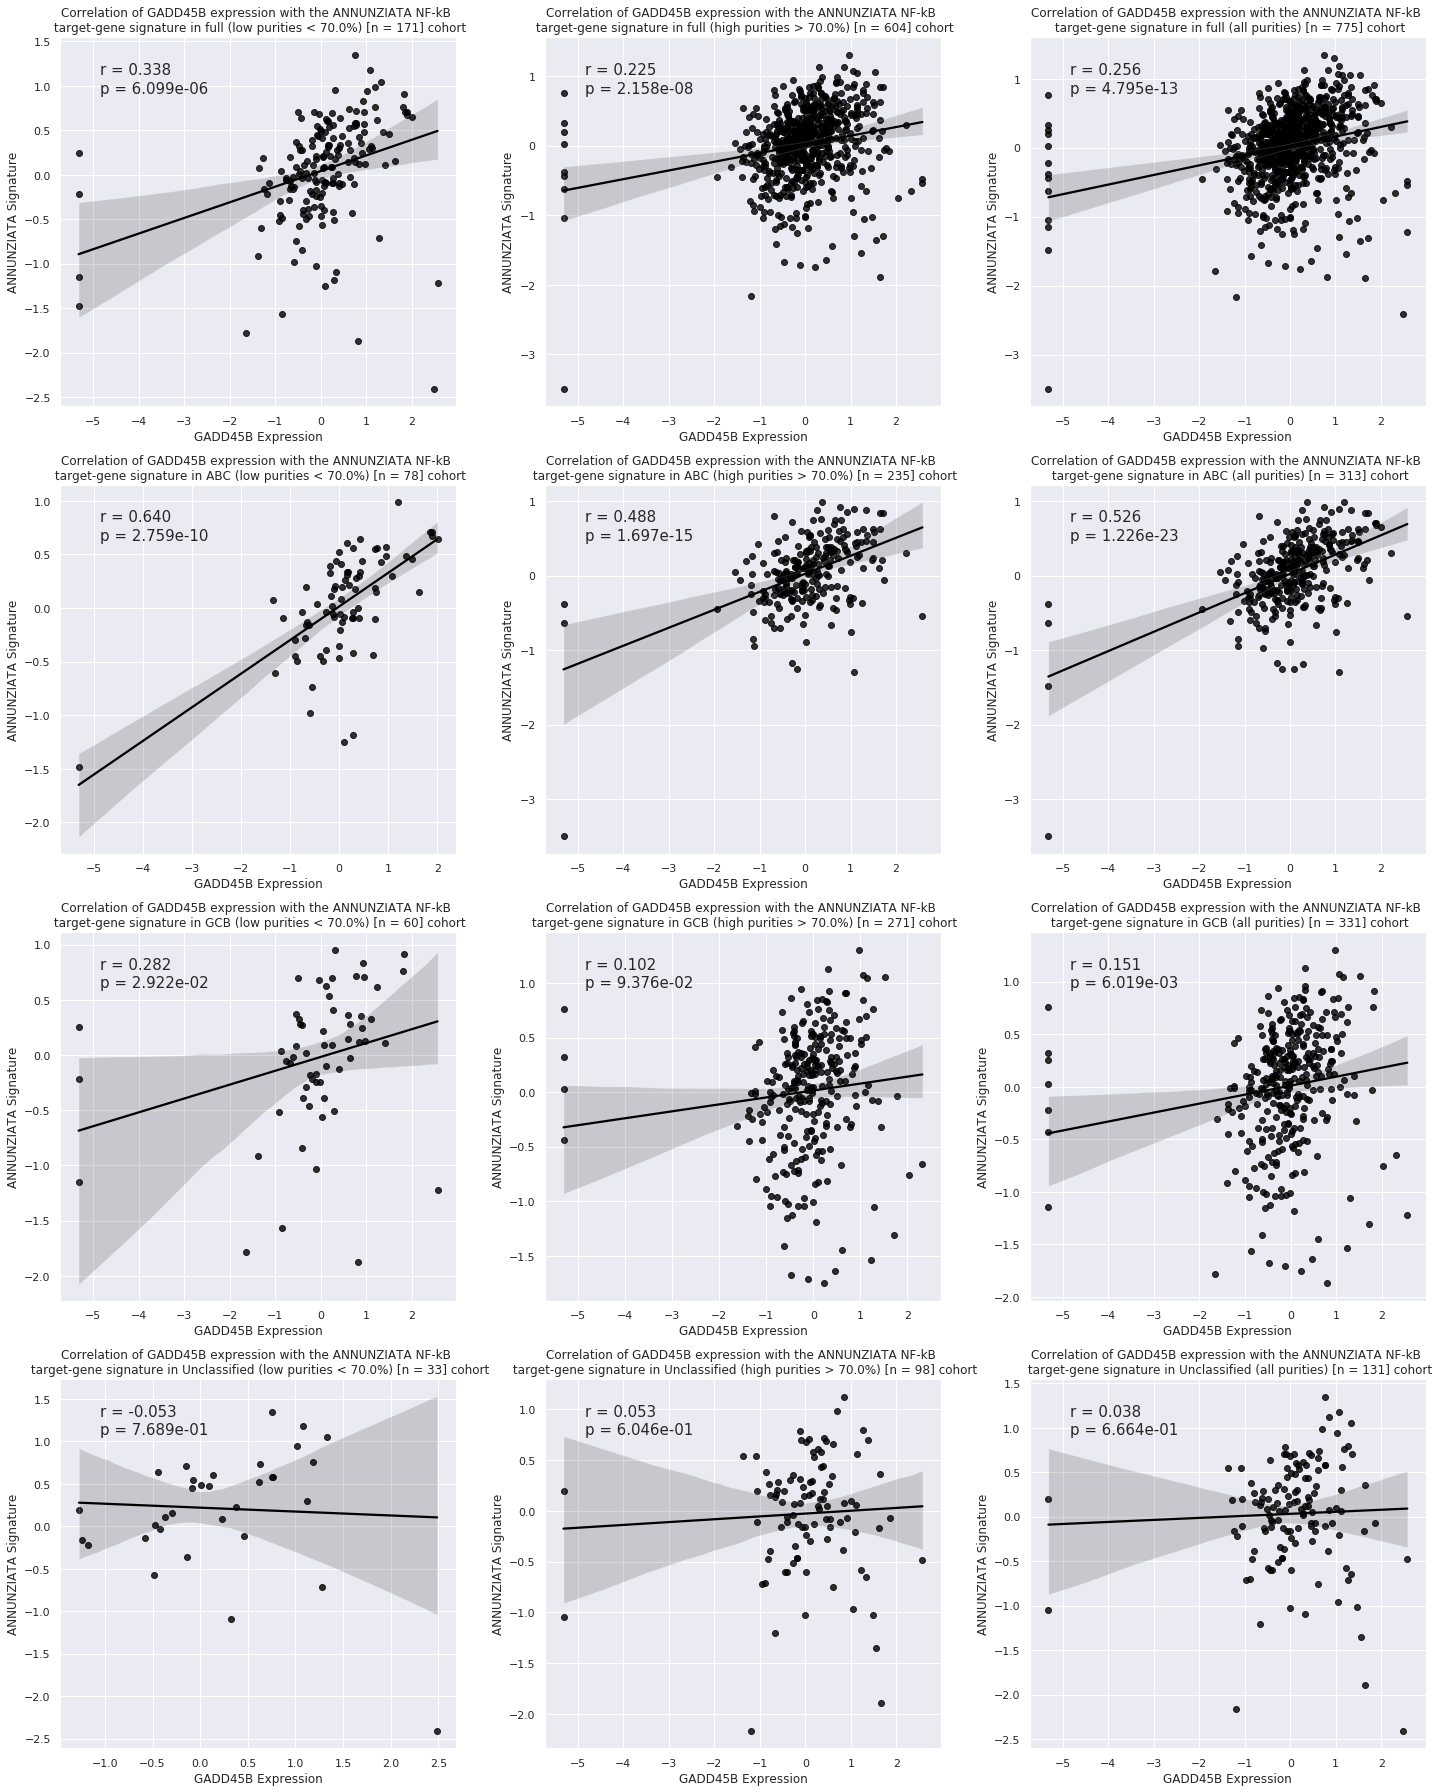

In [276]:
"""
ANNUNZIATA signature

The Reddy expression data is missing the [] genes used in the NF-kB ANNUNZIATA signature.
"""

plot_signature_purities('ANNUNZIATA', low_pur_thresh=0.7, high_pur_thresh=0.7)
plt.tight_layout()
plt.savefig('annun.png')

The Reddy expression data is missing the ['LOC100133660', 'C5orf41', 'IL8', 'FAM100B', 'LOC100129592', 'UNC84A', 'MIRN155', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB BROYL_NFKB_UP signature.

The Reddy expression data is missing the ['LOC100133660', 'C5orf41', 'IL8', 'FAM100B', 'LOC100129592', 'UNC84A', 'MIRN155', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB BROYL_NFKB_UP signature.

The Reddy expression data is missing the ['LOC100133660', 'C5orf41', 'IL8', 'FAM100B', 'LOC100129592', 'UNC84A', 'MIRN155', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB BROYL_NFKB_UP signature.

The Reddy expression data is missing the ['LOC100133660', 'C5orf41', 'IL8

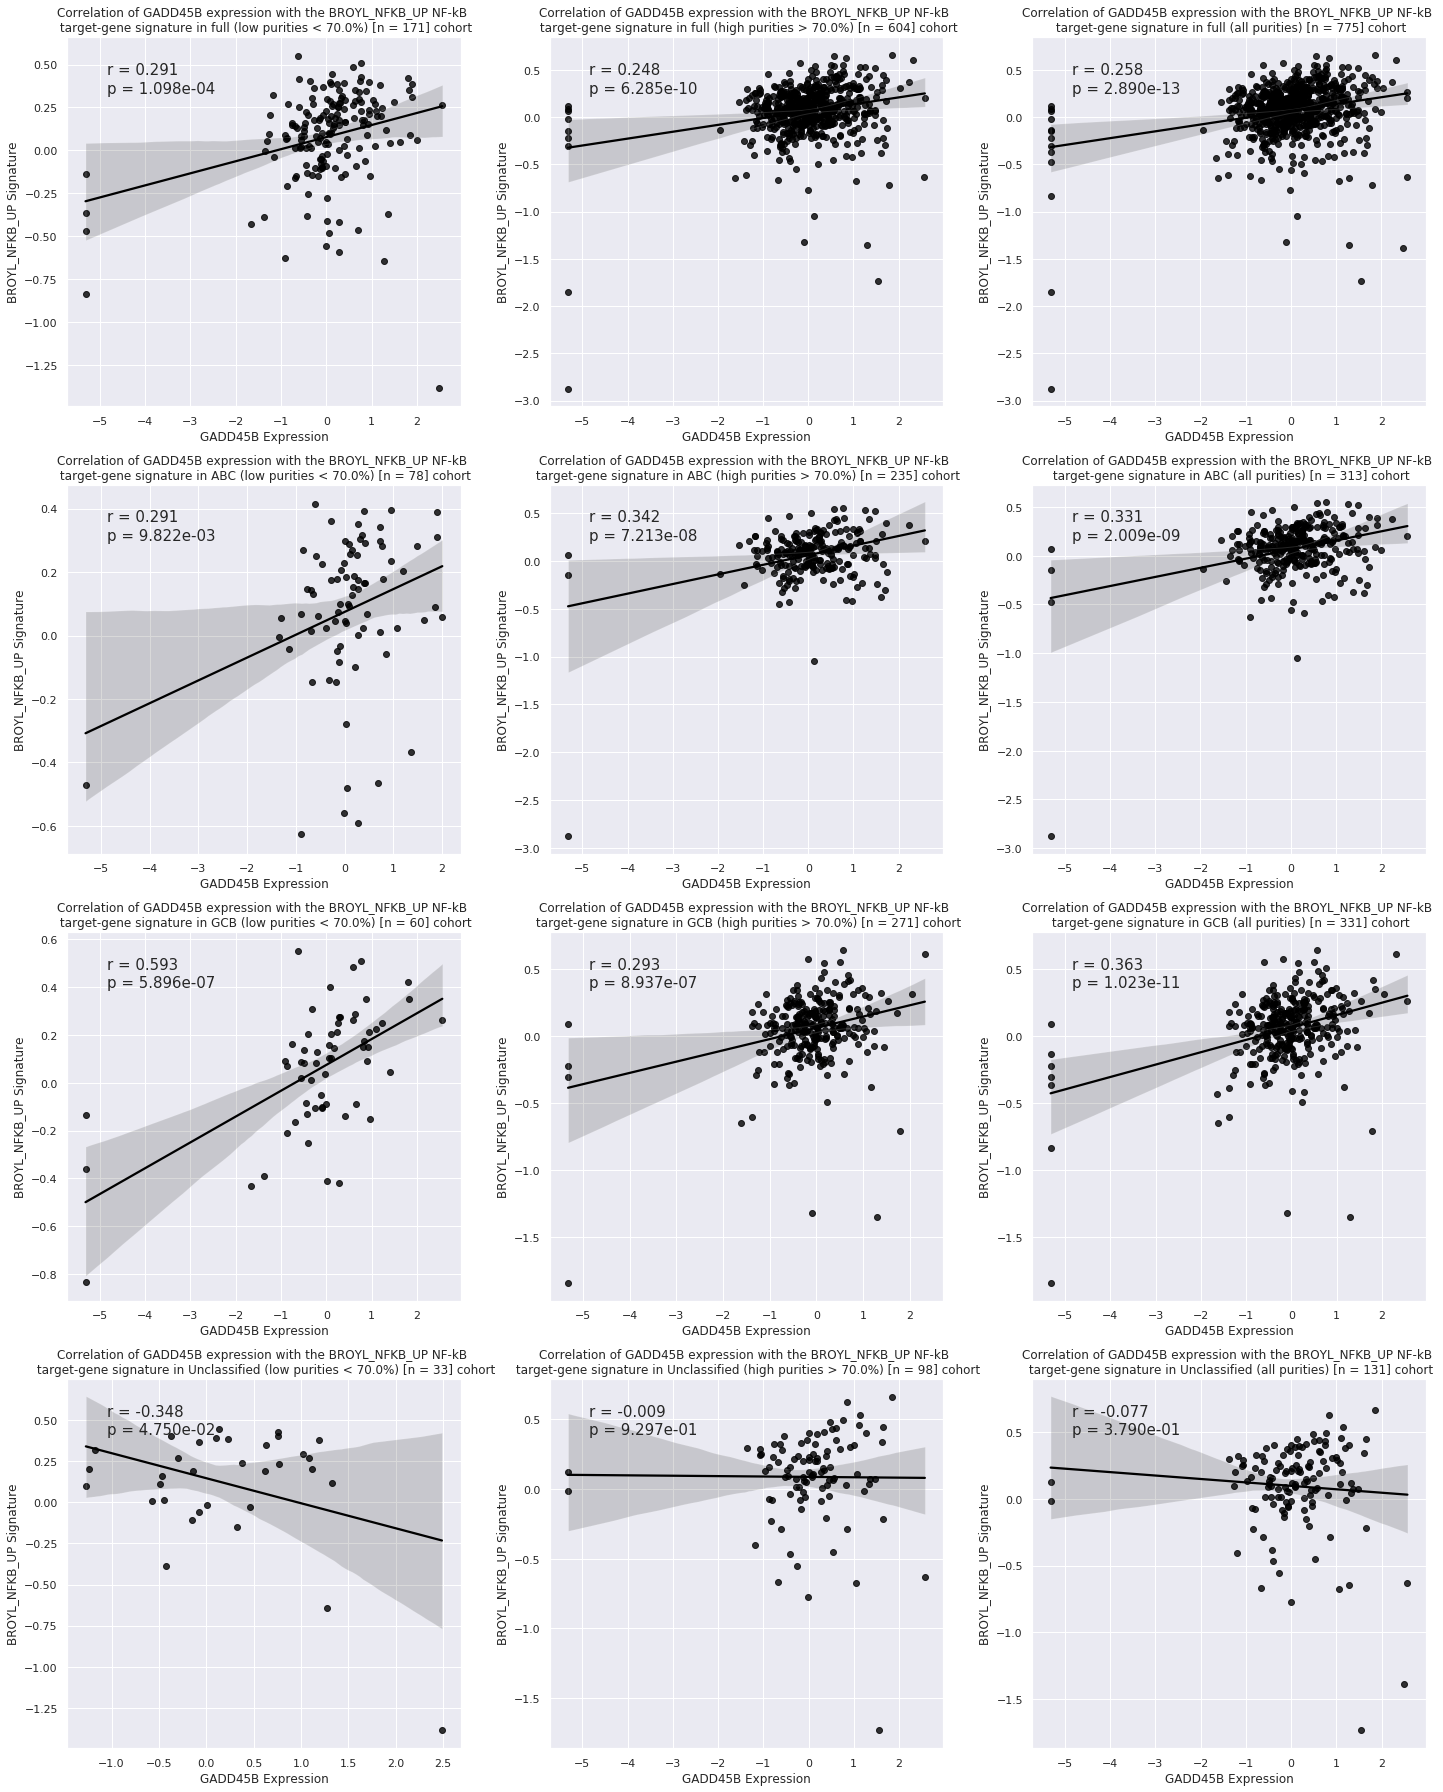

In [283]:
"""
BROYL_UP signature

The Reddy expression data is missing the ['LOC100133660', 'C5orf41', 'IL8', 'FAM100B', 
'LOC100129592', 'UNC84A', 'MIRN155'] genes used in the NF-kB BROYL_NFKB_UP signature.
"""

plot_signature_purities('BROYL_NFKB_UP', low_pur_thresh=0.7, high_pur_thresh=0.7)
plt.tight_layout()
plt.savefig('broyl.png')

The Reddy expression data is missing the ['IL8', 'CSF2', 'IL4RA', 'FCER2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB SHAFFER_NFKB_TARGET signature.

The Reddy expression data is missing the ['IL8', 'CSF2', 'IL4RA', 'FCER2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB SHAFFER_NFKB_TARGET signature.

The Reddy expression data is missing the ['IL8', 'CSF2', 'IL4RA', 'FCER2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] genes used in the NF-kB SHAFFER_NFKB_TARGET signature.

The Reddy expression data is missing 

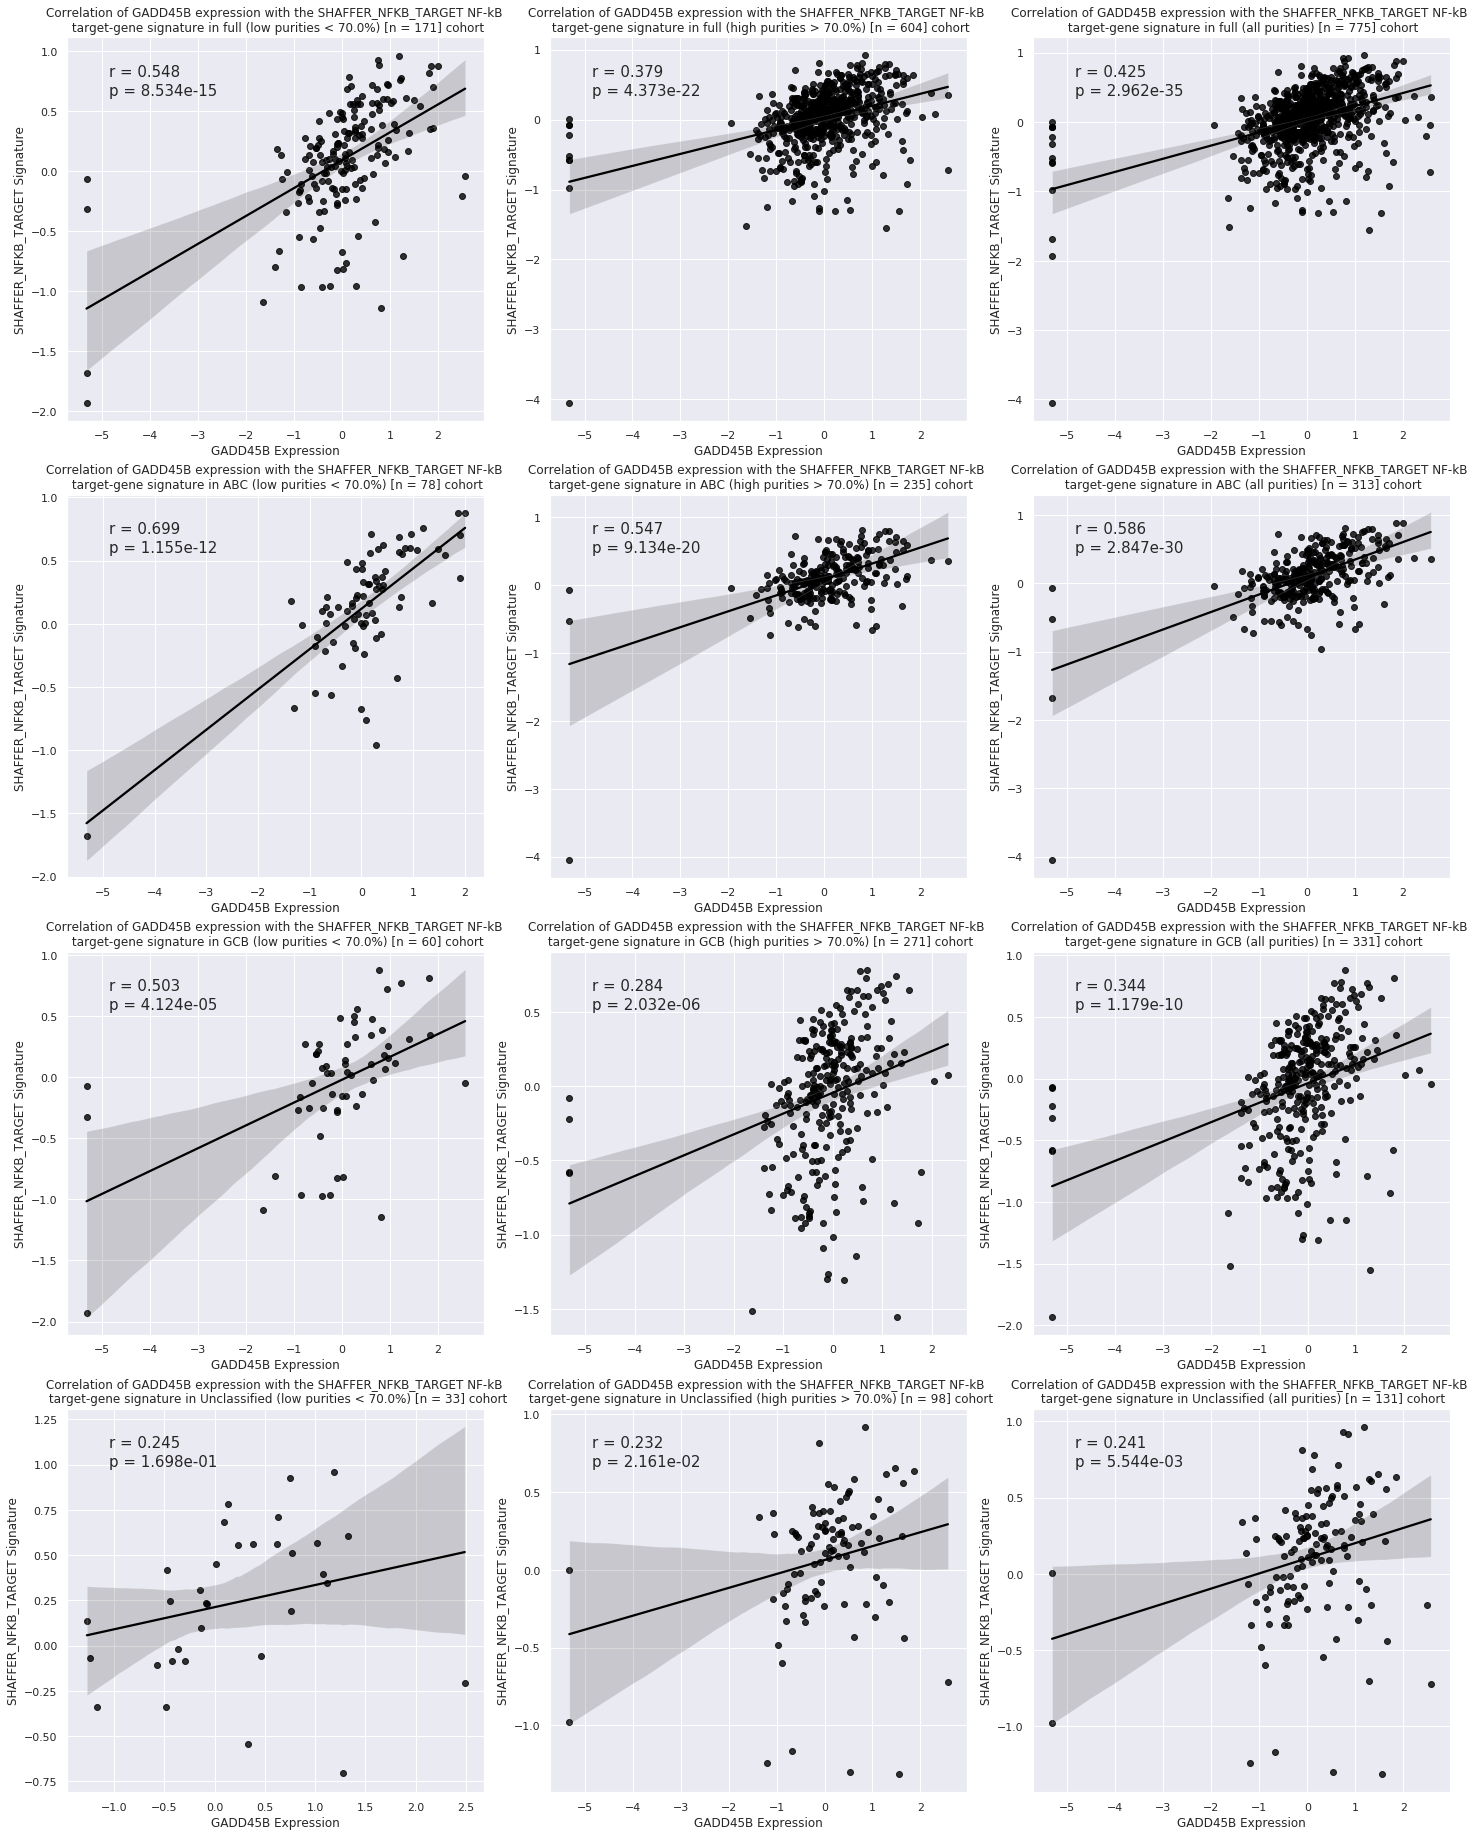

In [282]:
# other signatures
# SHAFFER_NFKB_TARGET missing 4, ok results: ABC: 0.586, GCB: 0.344 
# SHAFFER_NFKB_ACTIVATION: missing 2, usable results: ABC: 0.578, GCB: 0.254
# BIOCARTA_NFKB_PATHWAY missing 1, not good results; GILMORE_CORE_NFKB_PATHWAY missing 0, not good results
# HINATA_NFKB_IMMU_INF missing 7, bad results

plot_signature_purities('SHAFFER_NFKB_TARGET', low_pur_thresh=0.7, high_pur_thresh=0.7)

In [3]:
"""
CODE (not necessarily in order):
- Read in genetic alterations status data (binary data for whether patient has mutation for genes)
- Combine alteration status with reddy_info

NOTES:
- N/A

RELEVANT DATA:
- reddy_a := each patient's status for whether a driver gene is altered (1 is altered, 0 is unaltered)
- genes_altered := list of genes which have an alteration in some patient
- reddy_alterations := clinical info + tumor purity + GADD45B expression + gene alteration status

"""

# add genetic alteration data to reddy
reddy_a = pd.read_excel('full_reddy_s1.xlsx', sheet_name='Gene and Individual Information')

# make patient IDs columns
reddy_a.columns = reddy_a.iloc[1]

# delete two redundant rows
reddy_a = reddy_a.drop([0, 1])

# columns: genes, rows: patients -> transpose
reddy_a = np.transpose(reddy_a)

# delete two redundant rows
reddy_a = reddy_a.drop(['novel gene', 'Sample prevalence'])

# make gene IDs columns
reddy_a.columns = reddy_a.iloc[0]

# create list of altered genes
genes_altered = reddy_a.columns

# drop 'Genes' row
reddy_a = reddy_a.drop(['Genes'])

# make patient IDs a column for merging
reddy_a['Sample ID'] = reddy_a.index

# convert patient ID to int64 from float64 for merging
reddy_a['Sample ID'] = reddy_a['Sample ID'].astype('int64')

# merge reddy_info on sample ID to IDs on reddy_alterations
reddy_alterations = pd.merge(reddy_a, reddy_info, on='Sample ID', how='inner')

# replace GADD45B values with z-scores
reddy_alterations['GADD45B'] = reddy_norm['GADD45B']

In [166]:
"""
CODE (not necessarily in order):
- Read in genetic alterations status data (binary data for whether patient has mutation for genes)
- Combine alteration status with reddy_info

NOTES:
- N/A

RELEVANT DATA:
- N/A

"""

def create_mut_boxplot(df, mutated_gene, purity_label):

    no_mut = df.loc[df[gene] == 0]['GADD45B']
    mut = df.loc[df[gene] == 1]['GADD45B']
    
    # Create the boxplot
    bplot = sns.boxplot(y='GADD45B', x=mutated_gene, data=df, width=0.5, palette="colorblind")
    bplot.set(xlabel='Has mutation?', ylabel='Relative GADD45B mRNA levels')    
    bp_title = "Without [n = " + str(len(no_mut)) + "] / with [n = " + str(len(mut)) + "] \n" 
    bp_title = bp_title + mutated_gene + " alteration in " + purity_label + " cohort"
    bplot.set(title=bp_title)
    
    
    # t-test between pairs of cohorts
    _, t_p, _ = ttest_ind(no_mut, mut)
    t_p = round(t_p, 6)
    t_p_decision = "T-test: Don't reject H0" if (t_p >= 0.05) else "T-test: Can reject H0"
    plt.text(0.1, 2, "p = " + str(t_p) + "\n" + t_p_decision)
    
    """
    # welch's t-test between pairs of cohorts
    _, w_p = stats.ttest_ind(no_mutation, mutation, equal_var=False)
    w_p = round(w_p, 6)
    w_p_decision = "Welch t-test: Don't reject H0" if (w_p >= 0.05) else "Welch t-test: Can reject H0"
    plt.text(1.3, 2, "p = " + str(w_p) + "\n" + w_p_decision)
    """

# having issues making following into functions

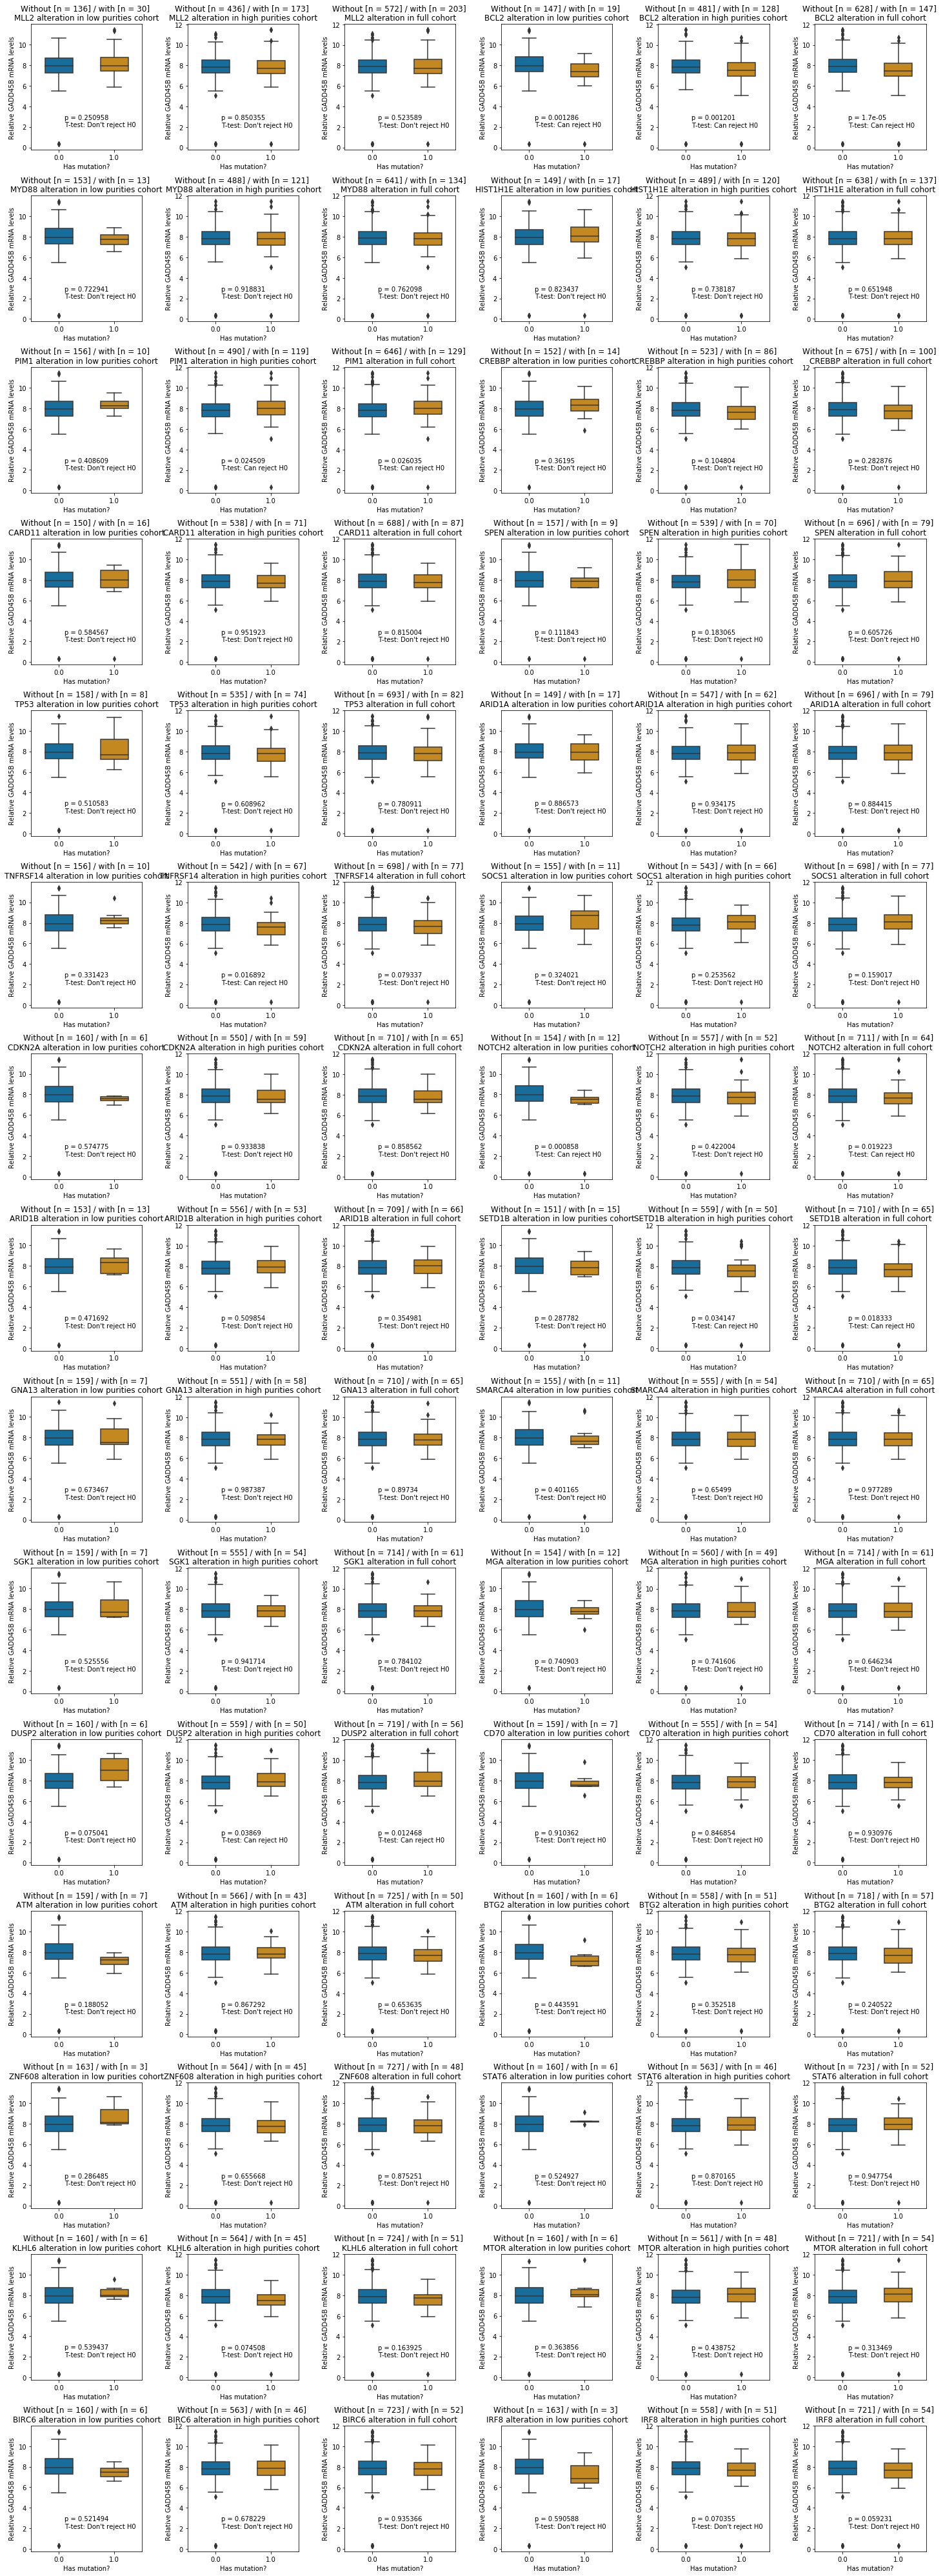

In [167]:
# there are 150 genes, showing first 30 genes here

fig, axarr = plt.subplots(15, 6, figsize=(20, 55))
fig.tight_layout(w_pad=4, h_pad=5)

chunk_size = 3

start_index = 0
end_index = 30

for i, gene in enumerate(genes_altered[start_index:end_index]):
    full_df = pd.merge(reddy_alterations[[gene, 'Sample ID', 'TumorPurity']], 
                             reddy[['GADD45B', 'Sample ID']], on='Sample ID', how='inner')
    low_df = full_df[full_df['TumorPurity'] < 0.6]
    high_df = full_df[full_df['TumorPurity'] > 0.6]

    plt.subplot(15, 6, (chunk_size*i)+1)
    create_mut_boxplot2(low_df, gene, "low purities")

    plt.subplot(15, 6, (chunk_size*i)+2)
    create_mut_boxplot2(high_df, gene, "high purities")

    plt.subplot(15, 6, (chunk_size*i)+3)
    create_mut_boxplot2(full_df, gene, "full")

# BCL2: lhf; PIM1: hf; TNFRSF14: h; NOTCH2: lf; SETD18: hf; DUSP2: hf

In [ ]:
# there are 150 genes, showing second 30 genes here

fig, axarr = plt.subplots(15, 6, figsize=(20, 55))
fig.tight_layout(w_pad=4, h_pad=5)

chunk_size = 3

start_index = 30
end_index = 60

for i, gene in enumerate(genes_altered[start_index:end_index]):
    full_df = pd.merge(reddy_alterations[[gene, 'Sample ID', 'TumorPurity']], 
                             reddy[['GADD45B', 'Sample ID']], on='Sample ID', how='inner')
    low_df = full_df[full_df['TumorPurity'] < 0.6]
    high_df = full_df[full_df['TumorPurity'] > 0.6]

    plt.subplot(15, 6, (chunk_size*i)+1)
    create_mut_boxplot2(low_df, gene, "low purities")

    plt.subplot(15, 6, (chunk_size*i)+2)
    create_mut_boxplot2(high_df, gene, "high purities")

    plt.subplot(15, 6, (chunk_size*i)+3)
    create_mut_boxplot2(full_df, gene, "full")
    
# IRF4: l PIK3CD: lf EZH2: hf ZNF292: l KLHL14: l FOXO1: h

In [ ]:
# there are 150 genes, showing third 30 genes here

fig, axarr = plt.subplots(15, 6, figsize=(20, 55))
fig.tight_layout(w_pad=4, h_pad=5)

chunk_size = 3

start_index = 60
end_index = 90

for i, gene in enumerate(genes_altered[start_index:end_index]):
    full_df = pd.merge(reddy_alterations[[gene, 'Sample ID', 'TumorPurity']], 
                             reddy[['GADD45B', 'Sample ID']], on='Sample ID', how='inner')
    low_df = full_df[full_df['TumorPurity'] < 0.6]
    high_df = full_df[full_df['TumorPurity'] > 0.6]

    plt.subplot(15, 6, (chunk_size*i)+1)
    create_mut_boxplot2(low_df, gene, "low purities")

    plt.subplot(15, 6, (chunk_size*i)+2)
    create_mut_boxplot2(high_df, gene, "high purities")

    plt.subplot(15, 6, (chunk_size*i)+3)
    create_mut_boxplot2(full_df, gene, "full")
    
# JAK3: h PRMD1: l UBE2A: h ZBTB7A: hf

In [ ]:
# there are 150 genes, showing fourth 30 genes here

fig, axarr = plt.subplots(15, 6, figsize=(20, 55))
fig.tight_layout(w_pad=4, h_pad=5)

chunk_size = 3

start_index = 90
end_index = 120

for i, gene in enumerate(genes_altered[start_index:end_index]):
    full_df = pd.merge(reddy_alterations[[gene, 'Sample ID', 'TumorPurity']], 
                             reddy[['GADD45B', 'Sample ID']], on='Sample ID', how='inner')
    low_df = full_df[full_df['TumorPurity'] < 0.6]
    high_df = full_df[full_df['TumorPurity'] > 0.6]

    plt.subplot(15, 6, (chunk_size*i)+1)
    create_mut_boxplot2(low_df, gene, "low purities")

    plt.subplot(15, 6, (chunk_size*i)+2)
    create_mut_boxplot2(high_df, gene, "high purities")

    plt.subplot(15, 6, (chunk_size*i)+3)
    create_mut_boxplot2(full_df, gene, "full")

# PIM2: h # a lot of rejections in some low purities because no patients with mutation

In [ ]:
# there are 150 genes, showing fifth 30 genes here

fig, axarr = plt.subplots(15, 6, figsize=(20, 55))
fig.tight_layout(w_pad=4, h_pad=5)

chunk_size = 3

start_index = 120
end_index = 150

for i, gene in enumerate(genes_altered[start_index:end_index]):
    full_df = pd.merge(reddy_alterations[[gene, 'Sample ID', 'TumorPurity']], 
                             reddy[['GADD45B', 'Sample ID']], on='Sample ID', how='inner')
    low_df = full_df[full_df['TumorPurity'] < 0.6]
    high_df = full_df[full_df['TumorPurity'] > 0.6]

    plt.subplot(15, 6, (chunk_size*i)+1)
    create_mut_boxplot2(low_df, gene, "low purities")

    plt.subplot(15, 6, (chunk_size*i)+2)
    create_mut_boxplot2(high_df, gene, "high purities")

    plt.subplot(15, 6, (chunk_size*i)+3)
    create_mut_boxplot2(full_df, gene, "full")

# RARA: lf # a lot of rejections in some low purities because no patients with mutation